In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [2]:
# KERAS DOCUMENTATION TO ENSURE REPRODUCIBLE RESULTS
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [3]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions

In [4]:
model = MobileNet()

In [5]:
test_img = image.load_img('./data/hotdog/train/hot_dog/1000288.jpg', target_size=(224,224))

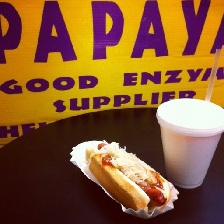

In [6]:
test_img

In [7]:
test_img_array = image.img_to_array(test_img)

In [8]:
test_img_probas = model.predict(test_img_array.reshape(1, 224, 224, 3))

In [9]:
decode_predictions(test_img_probas)

[[('n04209239', 'shower_curtain', 0.7166232),
  ('n03938244', 'pillow', 0.11363165),
  ('n02786058', 'Band_Aid', 0.03952434),
  ('n03291819', 'envelope', 0.027163178),
  ('n03196217', 'digital_clock', 0.020887656)]]

## Transfer Learning

- Borrow most of the weights of `MobileNet` to solve our hot dog vs not hot dog classification challenge.
- Take `MobileNet` layers, make last layer trainable and train it to solve our problem.


In [10]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [11]:
len(model.layers)

92

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [13]:
new_model = Sequential([ model.layers[i] for i in range(91) ])
new_model.trainable = False # We want to use MobileNet as "feature extractor". Weights in MB will be fixed.

In [14]:
new_model.add(Dense(128, activation='relu'))
new_model.add(Dense(2, activation='softmax'))

#### File generators to read only small batches of images

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input # MobileNet function to have correct format
        , horizontal_flip=True
        , vertical_flip=True
        , rotation_range=45
                               )

test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input # MobileNet function to have correct format
        #, horizontal_flip=True
        #, vertical_flip=True
                               )

In [17]:
train_data = train_datagen.flow_from_directory('./data/hotdog/train/', batch_size=16)
test_data = test_datagen.flow_from_directory('./data/hotdog/test/', batch_size=16)

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [18]:
new_model.compile(loss='categorical_crossentropy', # for one-hot encoded categories
                  metrics=['accuracy'])

In [19]:
history = new_model.fit(x = train_data, 
                  epochs = 10,
                  validation_data = test_data,
                       )

Epoch 1/10
32/32 [==============================] - 47s 1s/step - loss: 2.4724 - accuracy: 0.5020 - val_loss: 2.8923 - val_accuracy: 0.5020
Epoch 2/10
32/32 [==============================] - 42s 1s/step - loss: 2.6000 - accuracy: 0.5161 - val_loss: 2.8923 - val_accuracy: 0.5020
Epoch 3/10
32/32 [==============================] - 45s 1s/step - loss: 2.6158 - accuracy: 0.5020 - val_loss: 2.8923 - val_accuracy: 0.5020
Epoch 4/10
32/32 [==============================] - 42s 1s/step - loss: 2.6194 - accuracy: 0.5000 - val_loss: 2.8923 - val_accuracy: 0.5020
Epoch 5/10
32/32 [==============================] - 46s 1s/step - loss: 2.6011 - accuracy: 0.5040 - val_loss: 2.8923 - val_accuracy: 0.5020
Epoch 6/10
32/32 [==============================] - 45s 1s/step - loss: 2.4800 - accuracy: 0.5040 - val_loss: 2.8923 - val_accuracy: 0.5020
Epoch 7/10
32/32 [==============================] - 52s 2s/step - loss: 2.7201 - accuracy: 0.5000 - val_loss: 2.8923 - val_accuracy: 0.5020
Epoch 8/10
32/32 [==

### Diagnosing predictions

In [20]:
new_model.predict(test_img_array.reshape(1,224,224,3))

array([[0.0025994 , 0.99740064]], dtype=float32)

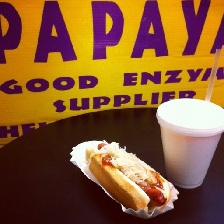

In [26]:
test_img

In [22]:
test_probas = new_model.predict(test_data)

In [23]:
test_preds = np.argmax(test_probas, axis=1)

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
confusion_matrix(test_data.classes, test_preds)

array([[ 13, 237],
       [ 18, 232]], dtype=int64)

In [ ]:
t